In [10]:
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [86]:
viridis = cm.get_cmap('Set1')

## Reference Data

In [87]:
data = np.load("./tmp/single-letter-kSys1-kEnvMax1.lambdas.tar.gz-best.npz")
qs_single_letter = data["qs"]

## Run Data

In [88]:
data = np.load("./tmp/all-graphs-IFPQ====-kSys2-kEnvMax2.lambdas.tar.gz-best.npz")
qs = data["qs"]

In [89]:
# which of the above graph's points protrude further
better_mask = np.sum(qs, axis=-1) > np.sum(qs_single_letter, axis=-1)
np.sum(better_mask)

qs_best = qs_single_letter
qs_best[better_mask] = qs[better_mask]

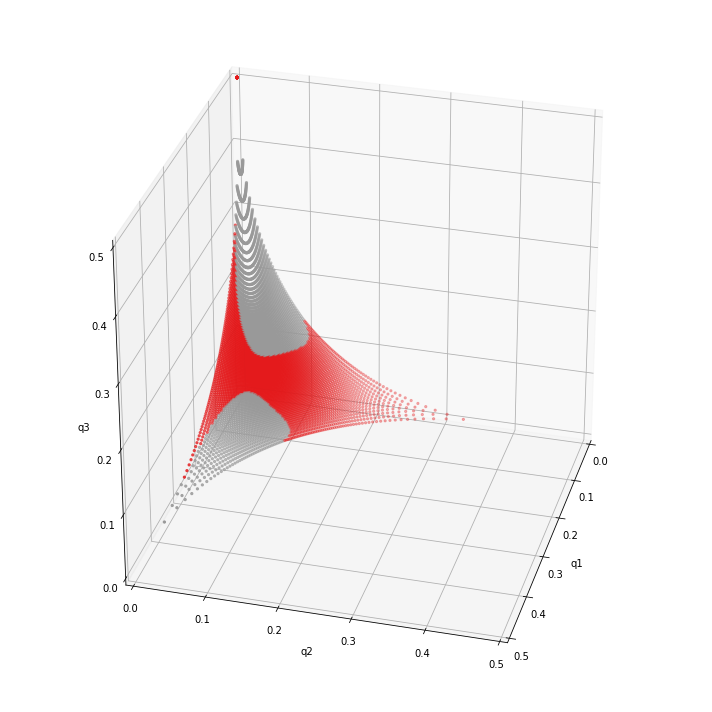

In [91]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=15)

q1,q2,q3 = qs_best.transpose()
ax.scatter(q1, q2, q3, marker=".", c=viridis(better_mask.astype("float")))

ax.set_xlabel("q1")
ax.set_ylabel("q2")
ax.set_zlabel("q3")

ax.set_xlim(0, .5)
ax.set_ylim(0, .5) 
ax.set_zlim(0, .5)

plt.tight_layout()
plt.show()